In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
import matplotlib.pyplot as plt

df = pd.read_csv("../input/train.csv")
y = df['label'].values
X = df.drop(['label'], axis=1).values.reshape(-1, 28, 28)/255.

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_vae(latent_size, kl_coeff=1.0):
    encoder_input = Input((28,28,))
    x = Reshape((28,28,1))(encoder_input)
    x = ZeroPadding2D(padding=2)(x)
    for n in [32,64,128,128,128]:
        x = Conv2D(n, kernel_size=3, padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    z_mean = Dense(latent_size)(x)
    z_log_sigma = Dense(latent_size)(x)
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=K.shape(z_mean),
                                  mean=0., stddev=1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
    
    encoder = Model(encoder_input, [z_mean, z_log_sigma])
    encoder.summary()

    decoder = Sequential()
    decoder.add(InputLayer((latent_size,)))
    decoder.add(Dense(128))
    decoder.add(Reshape((1,1,128)))
    for n in [128,128,64,32,1]:
        decoder.add(UpSampling2D(size=2))
        decoder.add(Conv2D(n, kernel_size=3, padding='same'))
        decoder.add(Activation('relu'))
        decoder.add(BatchNormalization())
    decoder.add(Conv2D(1, kernel_size=3, padding='same'))
    decoder.add(Activation('sigmoid'))
    decoder.add(Cropping2D(cropping=2))
    decoder.add(Reshape((28,28,)))
    decoder.summary()
    
    vae_output = decoder(z)
    vae = Model(encoder_input, vae_output)
    vae.summary()
    
    def vae_loss(y_true, y_pred):
        recon_loss = K.sum(K.square(y_true-y_pred), axis=[1,2])
        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
        return recon_loss + kl_coeff*kl_loss
    
    return encoder, decoder, vae, vae_loss

In [3]:
encoder, decoder, vae, vae_loss = make_vae(2, kl_coeff=1.)

vae.compile(optimizer='adam', loss=vae_loss, metrics=[])

epochs=100
vae.fit(X, X, 
        epochs=epochs,
        callbacks=[EarlyStopping(monitor='loss', patience=2)],
        verbose=2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 32, 32, 1)    0           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
activation

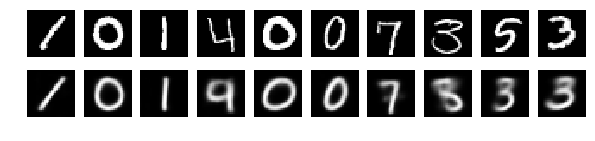

In [4]:
plt.figure(figsize=(10,2))
X_pred = vae.predict(X[:10])

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,10+i+1)
    plt.imshow(X_pred[i], cmap='gray')
    plt.axis('off')

Actual Image and Reconstructed Image

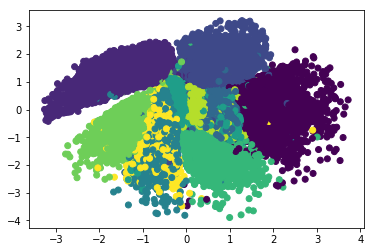

In [5]:
encoded = encoder.predict(X)
encoded_t = encoded[0].T
plt.scatter(encoded_t[0], encoded_t[1], c=y)

Latent space for each number sampling from that certain region generates required number

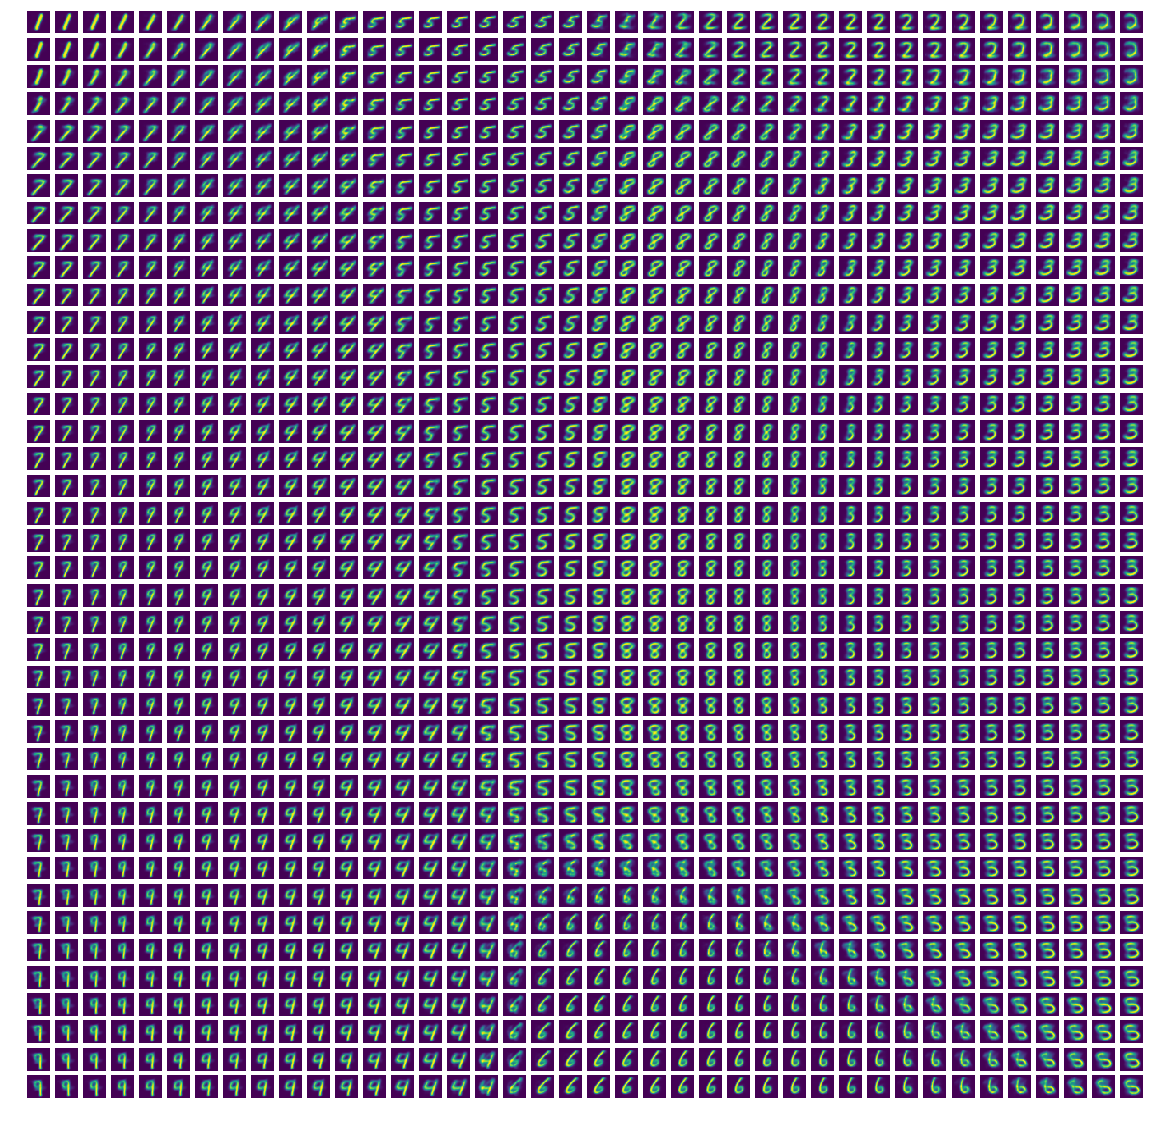

In [6]:
X,Y = np.meshgrid(np.arange(-1, 1, 0.05), np.arange(-1, 1, 0.05))
X = np.ravel(X)
Y = np.ravel(Y)
latents = np.stack([X, Y], axis=1)
generated = decoder.predict(latents)

plt.figure(figsize=(20,20))
for i in range(40):
    for j in range(40):
        plt.subplot(40,40,40*(39-i)+j+1)
        plt.imshow(generated[40*i+j])
        plt.axis('off')

numbers generated sequentially